In [92]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
import pylab as plot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,accuracy_score
import pickle
import time

In [93]:
from xgboost import XGBClassifier
import xgboost as xgb

In [94]:
#for scaling
from sklearn.preprocessing import StandardScaler

Importing training dataset

In [95]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [96]:
print(data.shape)

(867873, 10)


In [97]:
data.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'Id'],
      dtype='object')


Splitting the "Dates" into date and time

In [98]:
df=data.head(200000)
datetime=df.Dates.str.split(pat=" ",expand=True)
datetime.columns=['Date','Time']
#datetime

#------------test data-------------

df_test=test
datetime_test=df_test.Dates.str.split(pat=" ",expand=True)
datetime_test.columns=['Date','Time']

In [99]:
Date=datetime.Date.str.split(pat="-",expand=True)
Date.columns=['Year','Month','Day']

Time=datetime.Time.str.split(pat=":",expand=True)
Time.columns=['Hour','Minute','Second']

#------------test data-------------

Date_test=datetime_test.Date.str.split(pat="-",expand=True)
Date_test.columns=['Year','Month','Day']

Time_test=datetime_test.Time.str.split(pat=":",expand=True)
Time_test.columns=['Hour','Minute','Second']

Dropping the column of "Dates" and appending the dataframe "datetime"

In [100]:
df=pd.concat([df,Date,Time],axis=1)
#df

#-----------test data------------------

df_test=pd.concat([df_test,Date_test,Time_test],axis=1)


In [101]:
df=df.drop(labels=['Dates'],axis=1)

#-----------test data------------------

df_test=df_test.drop(labels=['Dates'],axis=1)


# #Encoding

In [102]:
df.columns

Index(['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution',
       'Address', 'X', 'Y', 'Id', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Second'],
      dtype='object')

LabelEncoding of "DayOfWeek" and "PdDistrict"

In [103]:
le = preprocessing.LabelEncoder()

In [104]:
#y=pd.get_dummies(df.Category,columns=['Category'],prefix=" ",prefix_sep=" ",drop_first=True,)

le_res=le.fit_transform(df['Category'])
y=pd.DataFrame(le_res)
y.columns=['Category']
#y

In [105]:
y['Category'].nunique()

36

# Rotation 60 degree

In [106]:
df["rot60_X"]=(0.5) * df["Y"] + (1.732/2) * df["X"]
df["rot60_Y"]=0.5 * df["Y"] - (1.732/2) * df["X"]



df_test["rot60_X"]=(0.5) * df_test["Y"] + (1.732/2) * df_test["X"]
df_test["rot60_Y"]=0.5 * df_test["Y"] - (1.732/2) * df_test["X"]

In [107]:
df["radial60"]=np.sqrt(np.power(df['rot60_X'],2) + np.power(df['rot60_Y'],2))

df_test["radial60"]=np.sqrt(np.power(df_test['rot60_X'],2) + np.power(df_test['rot60_Y'],2))

# Month clubbing

In [108]:
df=df.drop(labels='rot60_X',axis=1)

df_test=df_test.drop(labels='rot60_X',axis=1)

In [109]:
df=df.drop(labels='rot60_Y',axis=1)

df_test=df_test.drop(labels='rot60_Y',axis=1)

In [110]:
df=df.drop(labels='Second',axis=1)

df_test=df_test.drop(labels='Second',axis=1)

# Minute Clubbing

In [111]:
df['Minute']=df['Minute'].apply(lambda x:int(x))
df['Minute']=df['Minute'].apply(lambda x : 'low' if x <31 else 'high')

df_test['Minute']=df_test['Minute'].apply(lambda x:int(x))
df_test['Minute']=df_test['Minute'].apply(lambda x : 'low' if x <31 else 'high')


# DayOfWeek

In [112]:
df['DayOfWeek']= df['DayOfWeek'].apply(lambda x : 'WeekHigh' if x in ('Wednesday','Friday') else ('WeekMed' if x in ('Tuesday','Thursday','Saturday') else 'WeekLow'))


df_test['DayOfWeek']= df_test['DayOfWeek'].apply(lambda x : 'WeekHigh' if x in ('Wednesday','Friday') else ('WeekMed' if x in ('Tuesday','Thursday','Saturday') else 'WeekLow'))


# Address Update

In [113]:
df['Intersection']=df['Address'].apply(lambda x : 1 if '/' in x else 0)
df['Block']=df['Address'].apply(lambda x : 1 if 'Block' in x else 0)
df_test['Intersection']=df_test['Address'].apply(lambda x : 1 if '/' in x else 0)
df_test['Block']=df_test['Address'].apply(lambda x : 1 if 'Block' in x else 0)

In [114]:
address=pd.DataFrame(df['Address'],columns=['Address'])
address=address.Address.str.split(pat=" /",expand=True )

address.columns=['Address','Intr2']

address=address.Address.str.split(pat=" /",expand=True )
address.columns=['Address']

string=address.iloc[:,0]
string=string.str.strip()

address_fram=string.to_frame()
temp=address_fram['Address'].astype(str).str[-2:]

address=temp.to_frame()

address['Address']=address['Address'].apply(lambda x :( x if x in ("ST","AV","LN","DR","BL","HY","CT","RD","PL","PZ","TR","AL","CR","WK","EX","RW") else (("I-80" if x in ("80") else ("HWY" if x in ("WY") else ("WAY" if x in ("AY") else ("TER" if x in ("ER") else ("ALMS" if x in ("MS") else ("MAR" if x in ("AR") else ("PARK" if x in ("RK") else ("STWY" if x in ("WY") else ("VIA" if x in ("NO") else ("BLOCK")))))))))))))
df=df.drop(labels=['Address'],axis=1)
df=pd.concat([address,df],axis=1)



# Address splitting

In [115]:
address_test=pd.DataFrame(df_test['Address'],columns=['Address'])
address_test=address_test.Address.str.split(pat=" /",expand=True )

address_test.columns=['Address','Intr2']

address_test=address_test.Address.str.split(pat=" /",expand=True )
address_test.columns=['Address']

string_test=address_test.iloc[:,0]
string_test=string_test.str.strip()

address_fram_test=string_test.to_frame()
temp_test=address_fram_test['Address'].astype(str).str[-2:]

address_test=temp_test.to_frame()

address_test['Address']=address_test['Address'].apply(lambda x :( x if x in ("ST","AV","LN","DR","BL","HY","CT","RD","PL","PZ","TR","AL","CR","WK","EX","RW") else (("I-80" if x in ("80") else ("HWY" if x in ("WY") else ("WAY" if x in ("AY") else ("TER" if x in ("ER") else ("ALMS" if x in ("MS") else ("MAR" if x in ("AR") else ("PARK" if x in ("RK") else ("STWY" if x in ("WY") else ("VIA" if x in ("NO") else ("BLOCK")))))))))))))
df_test=df_test.drop(labels=['Address'],axis=1)
df_test=pd.concat([address_test,df_test],axis=1)

In [116]:
Id=df['Id']
df=df.drop(['Descript','Resolution','Id'],axis=1)

#----------test data---------

Id_test=df_test['Id']
df_test=df_test.drop(['Descript','Resolution','Id'],axis=1)

In [117]:
df_test.columns

Index(['Address', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [118]:
data['PdDistrict'].unique()

array(['MISSION', 'SOUTHERN', 'BAYVIEW', 'CENTRAL', 'INGLESIDE',
       'NORTHERN', 'RICHMOND', 'TARAVAL', 'TENDERLOIN', 'PARK'],
      dtype=object)

# Label Encoding

In [119]:

df.columns

Index(['Address', 'Category', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year',
       'Month', 'Day', 'Hour', 'Minute', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [120]:
df_test.columns

Index(['Address', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [121]:
le = preprocessing.LabelEncoder()

Label Encoding :DayOfWeek

In [122]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['DayOfWeek'])
Day=pd.DataFrame(le_res)
Day.columns=['DayOfWeek']
df=df.drop(labels=['DayOfWeek'],axis=1)
df=pd.concat([Day,df],axis=1)

#----------test data----------

le_res_test=le.fit_transform(df_test['DayOfWeek'])
Day_test=pd.DataFrame(le_res_test)
Day_test.columns=['DayOfWeek']
df_test=df_test.drop(labels=['DayOfWeek'],axis=1)
df_test=pd.concat([Day_test,df_test],axis=1)

Label Encoding: PdDistrict

In [123]:

le_res=le.fit_transform(df['PdDistrict'])
District=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
District.columns=['District']
df=df.drop(labels=['PdDistrict'],axis=1)
df=pd.concat([District,df],axis=1)


le_res_test=le.fit_transform(df_test['PdDistrict'])
District_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
District_test.columns=['District']
df_test=df_test.drop(labels=['PdDistrict'],axis=1)
df_test=pd.concat([District_test,df_test],axis=1)


Label encoding: Year

In [124]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Year'])
Year=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Year.columns=['Year']
df=df.drop(labels=['Year'],axis=1)
df=pd.concat([Year,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Year'])
Year_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Year_test.columns=['Year']
df_test=df_test.drop(labels=['Year'],axis=1)
df_test=pd.concat([Year_test,df_test],axis=1)


Label encoding: Month

In [125]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Month'])
Month=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Month.columns=['Month']
df=df.drop(labels=['Month'],axis=1)
df=pd.concat([Month,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Month'])
Month_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Month_test.columns=['Month']
df_test=df_test.drop(labels=['Month'],axis=1)
df_test=pd.concat([Month_test,df_test],axis=1)


Label encoding: Day

In [126]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Day'])
Day=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Day.columns=['Day']
df=df.drop(labels=['Day'],axis=1)
df=pd.concat([Day,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Day'])
Day_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Day_test.columns=['Day']
df_test=df_test.drop(labels=['Day'],axis=1)
df_test=pd.concat([Day_test,df_test],axis=1)


Label encoding: Hour

In [127]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Hour'])
Hour=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Hour.columns=['Hour']
df=df.drop(labels=['Hour'],axis=1)
df=pd.concat([Hour,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Hour'])
Hour_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Hour_test.columns=['Hour']
df_test=df_test.drop(labels=['Hour'],axis=1)
df_test=pd.concat([Hour_test,df_test],axis=1)


Label encoding: Minute

In [128]:

le_res=le.fit_transform(df['Minute'])
Minute=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Minute.columns=['Minute']
df=df.drop(labels=['Minute'],axis=1)
df=pd.concat([Minute,df],axis=1)


le_res_test=le.fit_transform(df_test['Minute'])
Minute_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Minute_test.columns=['Minute']
df_test=df_test.drop(labels=['Minute'],axis=1)
df_test=pd.concat([Minute_test,df_test],axis=1)



#label encode street suffix

In [129]:
le_res=le.fit_transform(df['Category'])
cat=pd.DataFrame(le_res)
cat.columns=['Category']
df=df.drop(labels=['Category'],axis=1)
df=pd.concat([cat,df],axis=1)

df.columns

Index(['Category', 'Minute', 'Hour', 'Day', 'Month', 'Year', 'District',
       'DayOfWeek', 'Address', 'X', 'Y', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [130]:

le_res=le.fit_transform(df['Address'])
Address=pd.DataFrame(le_res)
Address.columns=['Address']
df=df.drop(labels=['Address'],axis=1)
df=pd.concat([Address,df],axis=1)
le_res=le.fit_transform(df_test['Address'])
Address_test=pd.DataFrame(le_res)
Address_test.columns=['Address']
df_test=df_test.drop(labels=['Address'],axis=1)
df_test=pd.concat([Address_test,df_test],axis=1)

In [131]:
df.head()

,Address,Category,Minute,Hour,Day,Month,Year,District,DayOfWeek,X,Y,radial60,Intersection,Block
0,17,27,0,17,27,5,10,3,0,-122.419331,37.762264,152.287276,0,1
1,17,17,0,2,18,1,1,7,2,-122.411340,37.781271,152.279998,0,1
2,17,13,1,0,13,10,4,7,0,-122.403405,37.775421,152.269705,0,1
3,2,24,1,18,26,11,4,0,2,-122.404715,37.730161,152.265674,0,1
4,17,21,1,17,8,8,9,7,1,-122.405239,37.785265,152.273137,1,0


In [132]:
from sklearn.decomposition import PCA
dimension=np.array(np.array(df.iloc[:,9:11]))
dimension

array([[-122.41933115,   37.76226434],
       [-122.41133956,   37.78127074],
       [-122.40340479,   37.77542071],
       ...,
       [-122.40340479,   37.77542071],
       [-122.45228966,   37.72569336],
       [-122.39095293,   37.73866256]])

In [133]:
pca = PCA(n_components=1)
dim=pca.fit_transform(dimension)
dim=pd.DataFrame(dim)
dim.columns=['X','Y']
df=df.drop(labels=['X','Y'],axis=1)
df=pd.concat([dim,df],axis=1)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [134]:
'''from sklearn.cluster import KMeans
v1=np.array(df.iloc[:,1:3])
kk=KMeans(n_clusters=36, random_state=0)
kk.fit(v1)'''

'from sklearn.cluster import KMeans\nv1=np.array(df.iloc[:,1:3])\nkk=KMeans(n_clusters=36, random_state=0)\nkk.fit(v1)'

In [135]:
'''#'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3'','A4'','A5'','A6'','A7'','A8'','A9'','A10'
kmean= pd.DataFrame(kk.transform(v1))
kmean.columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
df=df.drop(labels=['X','Y'],axis=1)
df=pd.concat([kmean,df],axis=1)'''

"#'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3'','A4'','A5'','A6'','A7'','A8'','A9'','A10'\nkmean= pd.DataFrame(kk.transform(v1))\nkmean.columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']\ndf=df.drop(labels=['X','Y'],axis=1)\ndf=pd.concat([kmean,df],axis=1)"

In [136]:
'''v1_test=np.array(df_test.iloc[:,1:3])
kmean_test= pd.DataFrame(kk.transform(v1_test))
kmean_test.columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
df_test=df_test.drop(labels=['X','Y'],axis=1)
df_test=pd.concat([kmean_test,df_test],axis=1)'''

"v1_test=np.array(df_test.iloc[:,1:3])\nkmean_test= pd.DataFrame(kk.transform(v1_test))\nkmean_test.columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']\ndf_test=df_test.drop(labels=['X','Y'],axis=1)\ndf_test=pd.concat([kmean_test,df_test],axis=1)"

In [137]:
'''#points = df[]
# create scatter plot
plt.scatter(kmean['X'], kmean['Y'], cmap='viridis')
#plt.xlim(-15,15)
#plt.ylim(-15,15)'''

"#points = df[]\n# create scatter plot\nplt.scatter(kmean['X'], kmean['Y'], cmap='viridis')\n#plt.xlim(-15,15)\n#plt.ylim(-15,15)"

In [138]:
df=df[['X','Y', 'Year','Hour','Minute','Address', 'Intersection','Block']]


df_test=df_test[[ 'X','Y', 'Year','Hour','Minute','Address', 'Intersection','Block']]
#'radial60'

In [139]:
df['Address'].nunique()

22

In [140]:
df_test['Address'].nunique()

18

In [141]:
df_test.columns

Index(['X', 'Y', 'Year', 'Hour', 'Minute', 'Address', 'Intersection', 'Block'], dtype='object')

In [142]:
A=df.corr()
A

,X,Y,Year,Hour,Minute,Address,Intersection,Block
X,1.000000,0.514219,-0.002224,0.002093,-0.041199,0.267500,0.037880,-0.037880
Y,0.514219,1.000000,-0.007168,-0.001880,0.002764,0.019535,0.015101,-0.015101
Year,-0.002224,-0.007168,1.000000,-0.006311,-0.017015,0.007528,-0.027789,0.027789
Hour,0.002093,-0.001880,-0.006311,1.000000,0.003766,0.000073,0.045934,-0.045934
Minute,-0.041199,0.002764,-0.017015,0.003766,1.000000,-0.021523,-0.039402,0.039402
Address,0.267500,0.019535,0.007528,0.000073,-0.021523,1.000000,0.053283,-0.053283
Intersection,0.037880,0.015101,-0.027789,0.045934,-0.039402,0.053283,1.000000,-1.000000
Block,-0.037880,-0.015101,0.027789,-0.045934,0.039402,-0.053283,-1.000000,1.000000


# Splitting into test and train


In [143]:
X=df

In [144]:
#splitting the dataset into the training set and test set
#from sklearn import model_selection as ms

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,shuffle=False)

In [145]:
X_test.head()

,X,Y,Year,Hour,Minute,Address,Intersection,Block
134000,-122.436724,37.778490,5,4,1,17,0,1
134001,-122.479590,37.738186,12,10,1,2,0,1
134002,-122.390417,37.735593,0,22,1,2,1,0
134003,-122.429615,37.730270,8,13,0,17,0,1
134004,-122.431310,37.780658,3,12,1,17,0,1


In [53]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.20,shuffle=False)

# XGBoost 

In [88]:
model1= xgb.XGBClassifier(objective='multi:softprob')


In [ ]:
model1.fit(X_train, y_train)
val_pred1=model1.predict(X_val)
test_pred1=model1.predict(X_test)
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

#print (log_loss(y_test,y_pred1));

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#y_pred1=pd.DataFrame(y_pred1)
val_pred1.columns=['Cat1']
test_pred1.columns=['Cat1']

In [ ]:
y_pred1.columns=['Cat1']

# LightGBM

In [146]:
import lightgbm as lgb

model2= lgb.LGBMClassifier(objective='multiclass')


In [147]:
model12= lgb.LGBMClassifier(objective='multiclass')

model12.fit(X_train,y_train)
y_final=model12.predict_proba(X_test)
print (log_loss(y_test,y_final));

2.3646891687818234


In [90]:
model1.fit(X_train, y_train)
val_pred2=model2.predict(X_val)
test_pred2=model2.predict(X_test)
val_pred2=pd.DataFrame(val_pred2)
test_pred2=pd.DataFrame(test_pred2)
#print (log_loss(y_test,y_pred1));

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NameError: name 'X_val' is not defined

In [85]:
val_pred2.columns=['Cat2']
test_pred2.columns=['Cat2']

In [102]:
df_val=pd.concat([X_val,val_pred1.iloc[:,0:],val_pred2.iloc[:,0:]],axis=1)
df_test=pd.concat([X_test.iloc[:,0:],test_pred1.iloc[:,0:],test_pred2.iloc[:,0:]],axis=1)



In [106]:
df_val=np.concatenate((np.array(X_val),np.array(val_pred1),np.array(val_pred2)),axis=1)


array([[-122.44484684,   37.7683459 ,    8.        , ...,    1.        ,
          16.        ,   16.        ],
       [-122.50241658,   37.77917182,    5.        , ...,    1.        ,
          16.        ,   16.        ],
       [-122.43781544,   37.76171035,    0.        , ...,    1.        ,
          16.        ,   16.        ],
       ...,
       [-122.42981434,   37.77308732,    2.        , ...,    1.        ,
          16.        ,    1.        ],
       [-122.42028335,   37.77584894,    0.        , ...,    1.        ,
          34.        ,   34.        ],
       [-122.41846775,   37.78796526,    2.        , ...,    0.        ,
          16.        ,   18.        ]])

In [112]:
df_test=np.concatenate((np.array(X_test),np.array(test_pred1),np.array(test_pred2)),axis=1)

In [113]:
df_val=pd.DataFrame(df_val)
df_test=pd.DataFrame(df_test)

In [114]:
df_val.columns=['X','Y', 'Year','Hour','Minute','Address', 'Intersection','Block','Category1','Category2']
df_test.columns=['X','Y', 'Year','Hour','Minute','Address', 'Intersection','Block','Category1','Category2']

In [115]:
df_test

,X,Y,Year,Hour,Minute,Address,Intersection,Block,Category1,Category2
0,-122.436724,37.778490,5.0,4.0,1.0,17.0,0.0,1.0,16.0,4.0
1,-122.479590,37.738186,12.0,10.0,1.0,2.0,0.0,1.0,20.0,20.0
2,-122.390417,37.735593,0.0,22.0,1.0,2.0,1.0,0.0,21.0,21.0
3,-122.429615,37.730270,8.0,13.0,0.0,17.0,0.0,1.0,21.0,20.0
4,-122.431310,37.780658,3.0,12.0,1.0,17.0,0.0,1.0,16.0,16.0
5,-122.419039,37.790788,7.0,1.0,1.0,17.0,1.0,0.0,22.0,22.0
6,-122.396168,37.782724,9.0,11.0,1.0,17.0,0.0,1.0,16.0,16.0
7,-122.426452,37.798183,11.0,12.0,1.0,17.0,0.0,1.0,16.0,16.0
8,-122.423049,37.785240,9.0,15.0,1.0,17.0,0.0,1.0,16.0,16.0
9,-122.416078,37.762035,3.0,21.0,0.0,17.0,1.0,0.0,22.0,22.0


In [116]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression()
model3.fit(df_val,y_val)
y_final=model3.predict_proba(df_test)
print (log_loss(y_test,y_final));

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2.5618934288621786


In [117]:
from sklearn.ensemble import RandomForestClassifier
model3= RandomForestClassifier(criterion = 'entropy',random_state = 0)
model3.fit(df_val,y_val)
y_final=model3.predict_proba(df_test)
print (log_loss(y_test,y_final));

C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


15.638996018773671


In [118]:
from sklearn.naive_bayes import GaussianNB
model3 = GaussianNB()
model3.fit(df_val,y_val)
y_final=model3.predict_proba(df_test)
print (log_loss(y_test,y_final));

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


7.035707092672648


In [119]:
model3= lgb.LGBMClassifier(objective='multiclass')

model3.fit(df_val,y_val)
y_final=model3.predict_proba(df_test)
print (log_loss(y_test,y_final));

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2.438475872897519


In [120]:
from catboost import CatBoostClassifier

ModuleNotFoundError: No module named 'catboost'

In [65]:
y_pred2=pd.DataFrame(y_pred2)
y_pred2.columns=['Cat2']

In [66]:
df_val=pd.concat([X_test, y_pred1,y_pred2],axis=1)

In [69]:
df_val

,X,Y,Year,Hour,Minute,Address,Intersection,Block,Cat1,Cat2
0,-122.419331,37.762264,10.0,17.0,0.0,17.0,0.0,1.0,21.0,21.0
1,-122.411340,37.781271,1.0,2.0,0.0,17.0,0.0,1.0,20.0,20.0
2,-122.403405,37.775421,4.0,0.0,1.0,17.0,0.0,1.0,21.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0
4,-122.405239,37.785265,9.0,17.0,1.0,17.0,1.0,0.0,7.0,7.0
5,-122.418405,37.766760,11.0,6.0,1.0,17.0,1.0,0.0,16.0,20.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0
7,-122.410871,37.737526,9.0,12.0,0.0,17.0,0.0,1.0,21.0,21.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,20.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0


In [68]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(df_val,y_train)
y_final=model.predict_proba(X_test,y_test)
print (log_loss(y_test,y_pred1));

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [209]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors =36,weights='distance',algorithm='ball_tree',n_jobs=-1,p=1, metric = 'minkowski',leaf_size=60)

In [210]:
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier(n_estimators =20,criterion = 'entropy',random_state = 0)

In [100]:
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB()

# LogLoss


In [106]:
temp = data['Category']

le.fit_transform(temp)
le.classes_
y_pred= pd.DataFrame(y_pred, index=Id_test,columns  = le.classes_)
y_pred.to_csv("submit.csv", float_format = '%.5F')


In [107]:
# import statements
from sklearn.datasets import make_blobs

# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points


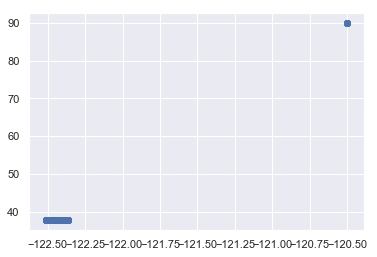

In [60]:
#points = df[]
# create scatter plot
plt.scatter(df['X'], df['Y'], cmap='viridis')
#plt.xlim(-15,15)
x#plt.ylim(-15,15)